# Training for financial transactions

In [1]:
import os
# data
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# math
import numpy as np

# sklearn
from sklearn import metrics

# display
from IPython.display import display

## Helper functions

In [20]:
# Print confusion matrix
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)'])

def plot_specificity_sensitivity(model_names, confusion_matrices):
    num_models = len(model_names)

    # Calculate sensitivity and specificity for each model
    tpr_values = []
    tnr_values = []

    for cm in confusion_matrices:
        tn, fp, fn, tp = cm.ravel()

        tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
        fnr = fn / (fn + tp)  # False Negative Rate (Miss Rate)
        tpr = tp / (tp + fn)  # True Positive Rate (Sensitivity/Recall)

        tpr_values.append(tpr)
        tnr_values.append(tnr)

    # Plotting Sensitivity and Specificity
    fig, ax = plt.subplots(figsize=(8, 6))

    index = np.arange(num_models)
    bar_width = 0.35
    opacity = 0.8

    rects1 = ax.bar(index, tpr_values, bar_width, alpha=opacity, color='red', label='Sensitivity')
    rects2 = ax.bar(index + bar_width, tnr_values, bar_width, alpha=opacity, color='blue', label='Specificity')

    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison - Sensitivity and Specificity')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(model_names)
    ax.legend()

    # Add labels to each bar
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

def plot_scores(model_names, scores, name):
    min_score = min(scores)
    y_min = min_score - 0.01
    y_max = 1.0
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(model_names, scores)

    ax.set_ylim([y_min, y_max])

    ax.set_title('Model Comparison - ' + name)
    ax.set_xlabel('Model')
    ax.set_ylabel(name)

    plt.xticks(rotation=45)

    plt.show()

## Analyse the data

Importing the data from the given csv sheet using pandas and analysing it's structure


In [3]:
# Import data
path = "./data" if os.path.exists("./data") else "."
data = pd.read_csv(os.path.join(path, "transactions.csv"))
# split the data columns:
X = data.drop("Class", axis=1)
y = data["Class"]
X_data = X.values
y_data = y.values
print(X_data.shape)
print(data.columns)


(227845, 30)
Index(['Time', 'Feature0', 'Feature1', 'Feature2', 'Feature3', 'Feature4',
       'Feature5', 'Feature6', 'Feature7', 'Feature8', 'Feature9', 'Feature10',
       'Feature11', 'Feature12', 'Feature13', 'Feature14', 'Feature15',
       'Feature16', 'Feature17', 'Feature18', 'Feature19', 'Feature20',
       'Feature21', 'Feature22', 'Feature23', 'Feature24', 'Feature25',
       'Feature26', 'Feature27', 'Amount', 'Class'],
      dtype='object')


### Correlation heatmap
Analyse the correlation in the data to find out if we can toss any columns

<Axes: >

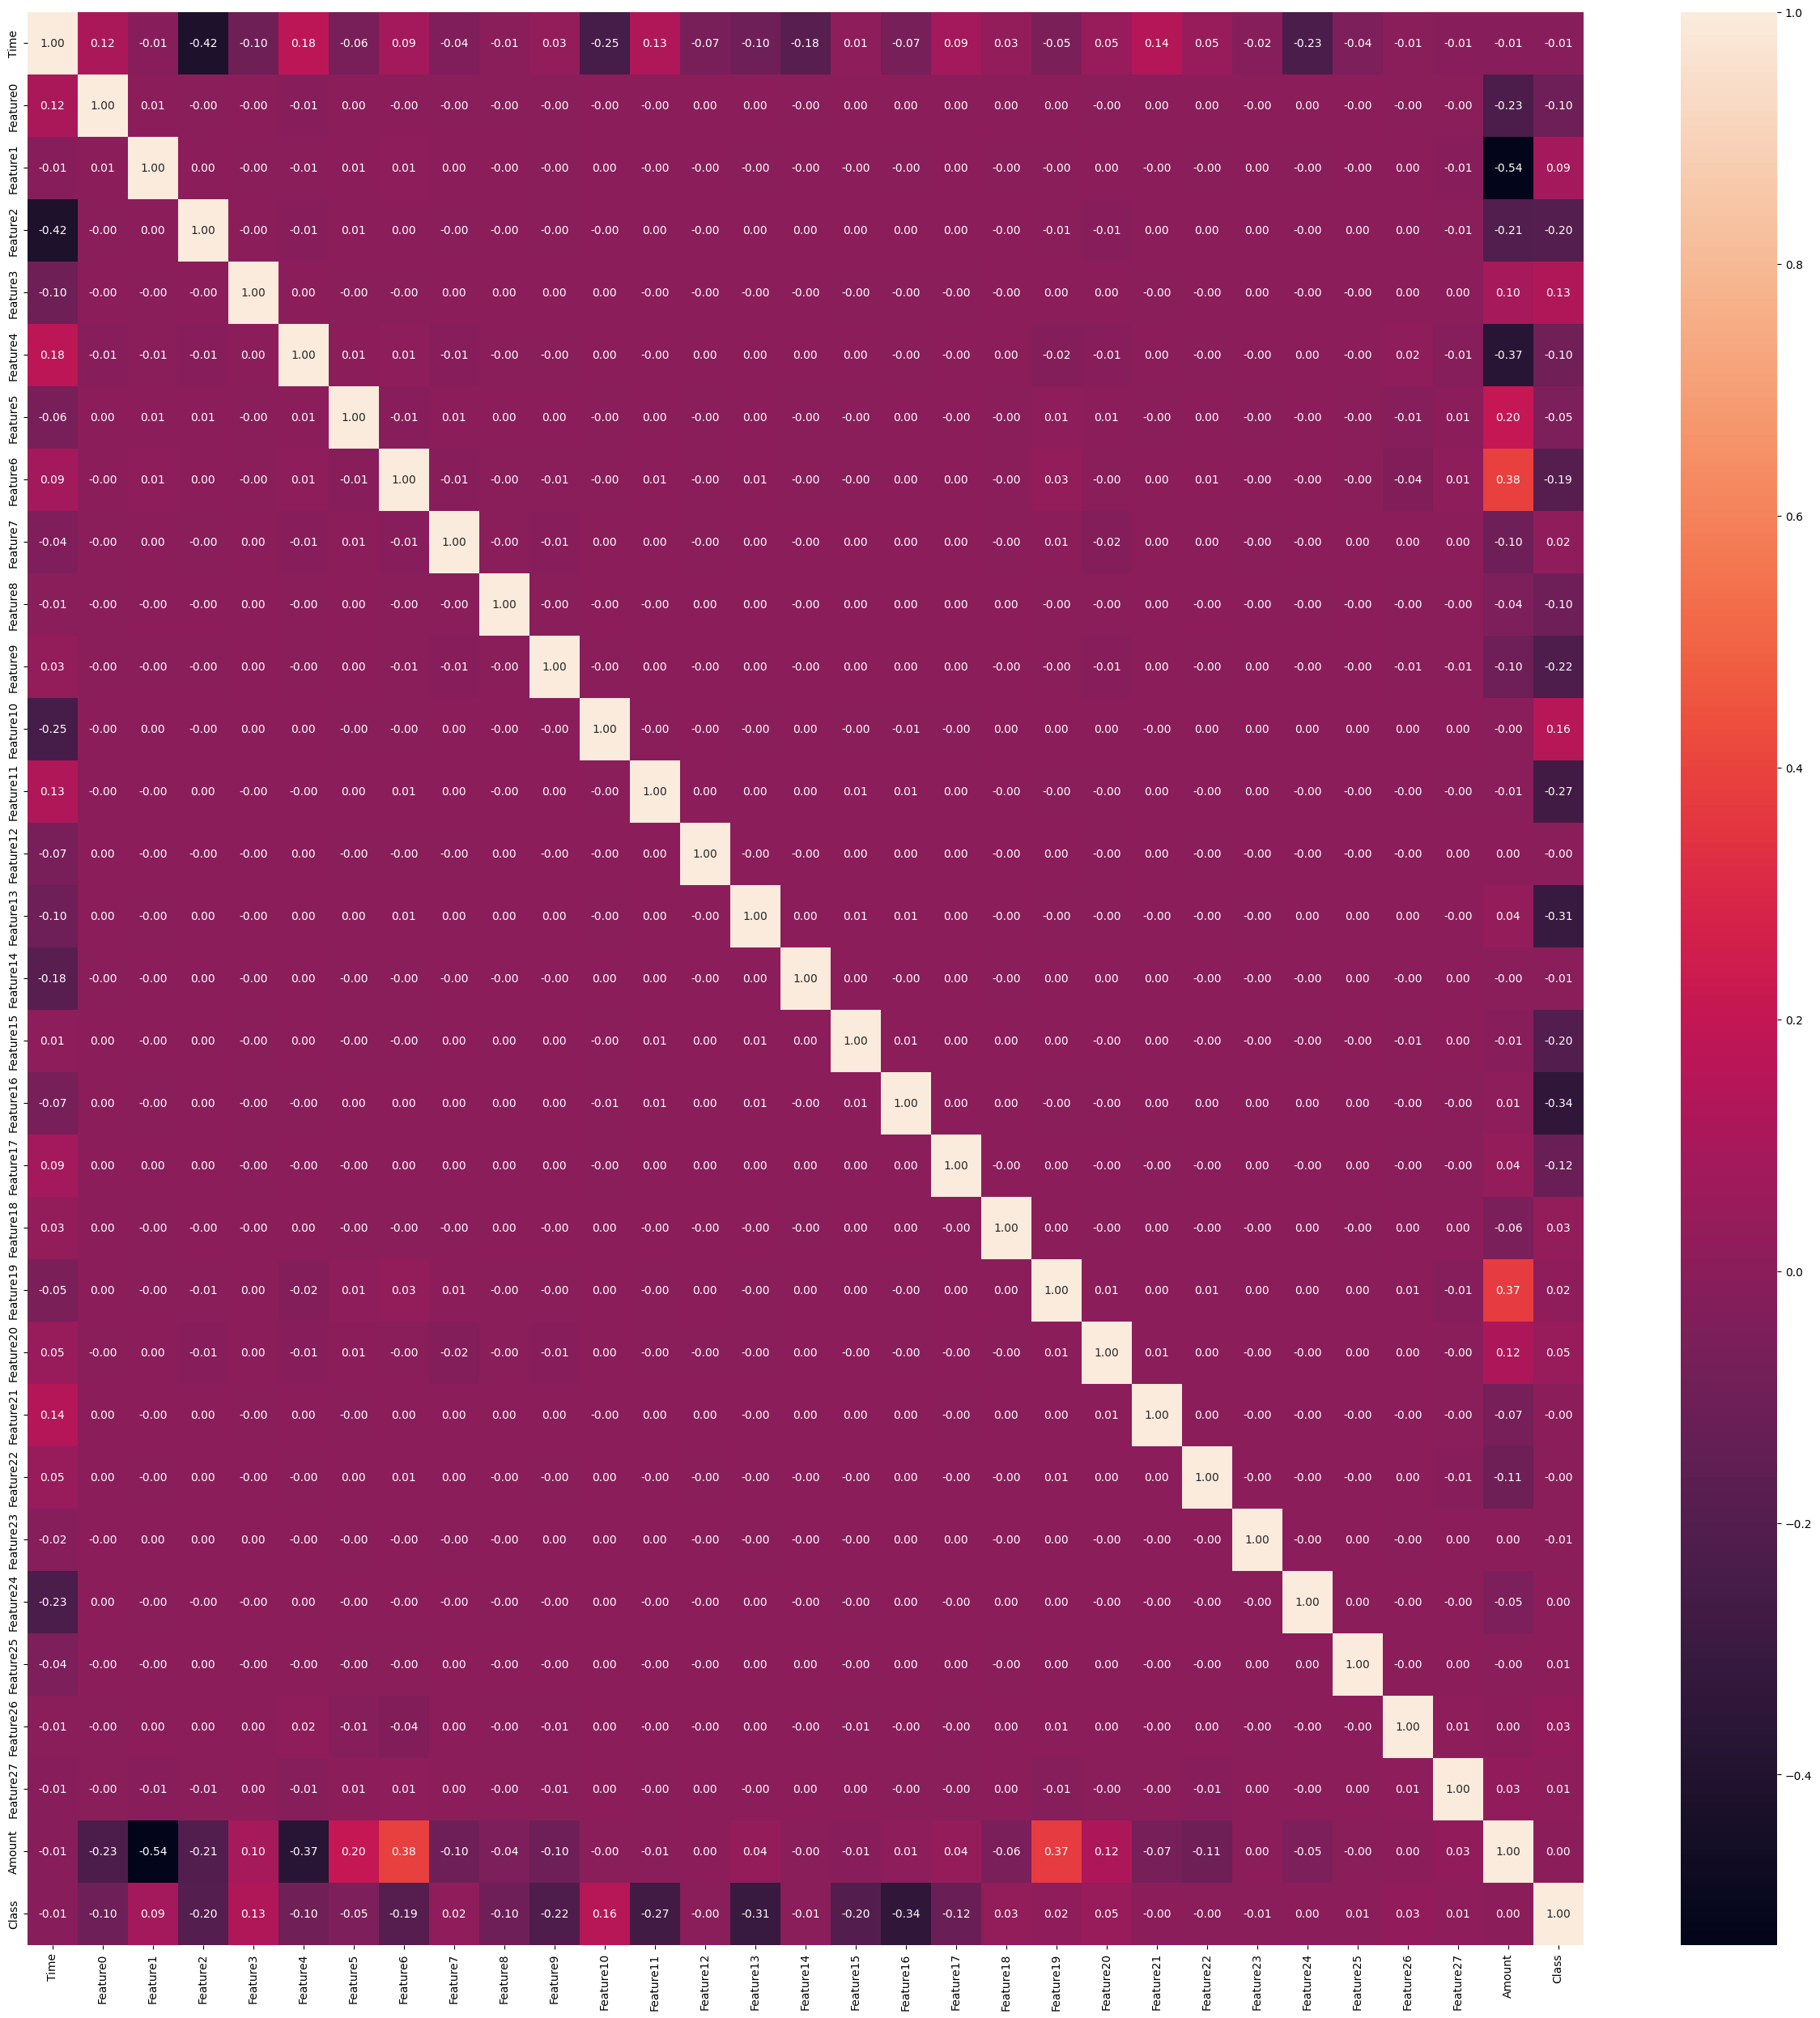

In [4]:
# find out about correlation and if we can eliminate some columns if they have high correlataion
plt.figure(figsize=(31,31))
sns.heatmap(data.corr(), annot=True, fmt='.2f')

As can be seen from this heatmap, the columns in the data show no significant correlation

### Dataset Balance

Find out how balanced the training data is by counting the number of entries corresponding to each label

In [5]:
count_classes = y.value_counts()
print(count_classes)

Class
0    227451
1       394
Name: count, dtype: int64


This dataset is highly imbalanced so we need to find a way to make this better for training

In [6]:
from sklearn.utils import resample

X_oversampled, y_oversampled = resample(X_data[y_data == 1], y_data[y_data == 1], replace=True, n_samples=X_data[y_data == 0].shape[0], random_state=42)

X_balanced = np.vstack((X_data[y_data == 0], X_oversampled))
y_balanced = np.hstack((y_data[y_data == 0], y_oversampled))

cols_without_class = data.columns.drop('Class')
new_X_df = pd.DataFrame(X_balanced, columns=cols_without_class)
new_y_df = pd.DataFrame(y_balanced, columns=['Class'])

balanced_data = pd.concat([new_X_df, new_y_df], axis=1)
print(balanced_data.value_counts('Class'))

Class
0    227451
1    227451
Name: count, dtype: int64


## Selecting a model

For a classification problem like this we have a variety of models to choose from like **Neural networks**, **Desicion trees**, **Random forests**, **Logicstic regression**, ...

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Define models
algorithms = [
    (
        "Logistic Regression",
        LogisticRegression(),
        {
            "penalty": ["l2"],
            "C": [0.001, 0.01, 0.1, 1, 10, 100],
            "class_weight": ["balanced", None, {0: 0.1, 1: 0.9}],
        }
    ),
    (
        "Decision Tree",
        DecisionTreeClassifier(),
        {
            "criterion": ["gini"],
            "max_depth": [5, 10, 15],
            "min_samples_split": [2, 5, 10],
            "class_weight": ["balanced", None, {0: 0.1, 1: 0.9}],
        },
    ),
    (
        "Random Forest",
        RandomForestClassifier(),
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5, 10],
            "class_weight": ["balanced", None, {0: 0.1, 1: 0.9}],
        },
    ),
    (
        "Neural Network",
        MLPClassifier(learning_rate_init=0.001),
        {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001, 0.01],
        },
    ),
]

### The training algorithm

In [28]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

def train_model(name, model, param_grid, X_train, y_train, X_test, y_test):
    print(f"Estimating hyperparameters for {name}, using param grid {param_grid} ...")

    # Estimate hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring="roc_auc", cv=n_fold, verbose=5)
    grid_search.fit(X_train, y_train)

    # Get the grid search results
    results = grid_search.cv_results_
    print(results)

    best_parameters = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"{name}")
    print(f"Best params: {best_parameters}, Best score: {best_score}")

    model.set_params(**best_parameters)

    print("Fitting models with best parameters...")
    model.fit(X_train, y_train)

    print(f'Fitted Model Parameters: {model.get_params()}\n')

    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"ROC AUC on testing data: {score:.4f}\n")
    print(f"Accuracy on testing data: {accuracy:.4f}\n")

    cm = confusion_matrix(y_test, y_pred)
    ((tn, fp), (fn, tp)) = confusion_matrix(y_test, y_pred)
    ((tnr,fpr),(fnr,tpr))= confusion_matrix(y_test, y_pred, 
            normalize='true')
    display(pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)']))
    return accuracy, score, cm


Use n-fold cross validation and prepare data

In [38]:
n_fold = 4

model_scores = []

log_reg = algorithms[0]
des_tree = algorithms[1]
rand_for = algorithms[2]
mlp = algorithms[3]

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2,
                                                    random_state=1, stratify=y_balanced)


### Logistic regression

In [44]:
# Train logistic regression
l_n, l_m, l_p_g = log_reg
log_reg_acc, log_reg_roc, log_reg_cm = train_model(l_n, l_m, l_p_g, X_train, y_train, X_test, y_test)

Estimating hyperparameters for Logistic Regression, using param grid {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced', None, {0: 0.1, 1: 0.9}]} ...
Fitting 4 folds for each of 18 candidates, totalling 72 fits


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END C=0.001, class_weight=balanced, penalty=l2;, score=0.977 total time=   2.8s
[CV 2/4] END C=0.001, class_weight=balanced, penalty=l2;, score=0.981 total time=   3.0s
[CV 3/4] END C=0.001, class_weight=balanced, penalty=l2;, score=0.982 total time=   2.5s
[CV 4/4] END C=0.001, class_weight=balanced, penalty=l2;, score=0.975 total time=   2.0s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END C=0.001, class_weight=None, penalty=l2;, score=0.977 total time=   2.8s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END C=0.001, class_weight=None, penalty=l2;, score=0.981 total time=   2.4s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/4] END C=0.001, class_weight=None, penalty=l2;, score=0.979 total time=   2.5s
[CV 4/4] END C=0.001, class_weight=None, penalty=l2;, score=0.975 total time=   2.2s
[CV 1/4] END C=0.001, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.1s
[CV 2/4] END C=0.001, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.971 total time=   1.3s
[CV 3/4] END C=0.001, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.4s
[CV 4/4] END C=0.001, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.1s
[CV 1/4] END C=0.01, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.4s
[CV 2/4] END C=0.01, class_weight=balanced, penalty=l2;, score=0.975 total time=   1.9s
[CV 3/4] END C=0.01, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.5s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=0.01, class_weight=balanced, penalty=l2;, score=0.982 total time=   2.6s
[CV 1/4] END C=0.01, class_weight=None, penalty=l2;, score=0.956 total time=   1.4s
[CV 2/4] END C=0.01, class_weight=None, penalty=l2;, score=0.975 total time=   2.2s
[CV 3/4] END C=0.01, class_weight=None, penalty=l2;, score=0.956 total time=   1.4s
[CV 4/4] END C=0.01, class_weight=None, penalty=l2;, score=0.976 total time=   2.2s
[CV 1/4] END C=0.01, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.5s
[CV 2/4] END C=0.01, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.971 total time=   1.5s
[CV 3/4] END C=0.01, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.4s
[CV 4/4] END C=0.01, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.5s
[CV 1/4] END C=0.1, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.3s
[CV 2/4] END C=0.1, class_weight=balanced, penalty=l2;, score=0.975 total time=   2.0s
[CV 3/4] END C=0.1

/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=0.1, class_weight=None, penalty=l2;, score=0.976 total time=   2.6s
[CV 1/4] END C=0.1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.1s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END C=0.1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.986 total time=   3.4s
[CV 3/4] END C=0.1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.7s
[CV 4/4] END C=0.1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.980 total time=   2.6s
[CV 1/4] END C=1, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.5s
[CV 2/4] END C=1, class_weight=balanced, penalty=l2;, score=0.975 total time=   2.0s
[CV 3/4] END C=1, class_weight=balanced, penalty=l2;, score=0.957 total time=   1.4s
[CV 4/4] END C=1, class_weight=balanced, penalty=l2;, score=0.976 total time=   2.4s
[CV 1/4] END C=1, class_weight=None, penalty=l2;, score=0.956 total time=   1.3s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END C=1, class_weight=None, penalty=l2;, score=0.979 total time=   2.9s
[CV 3/4] END C=1, class_weight=None, penalty=l2;, score=0.957 total time=   1.4s
[CV 4/4] END C=1, class_weight=None, penalty=l2;, score=0.976 total time=   2.7s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/4] END C=1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.8s
[CV 2/4] END C=1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.971 total time=   1.5s
[CV 3/4] END C=1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.9s
[CV 4/4] END C=1, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.980 total time=   3.0s
[CV 1/4] END C=10, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.4s
[CV 2/4] END C=10, class_weight=balanced, penalty=l2;, score=0.975 total time=   2.2s
[CV 3/4] END C=10, class_weight=balanced, penalty=l2;, score=0.957 total time=   1.3s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=10, class_weight=balanced, penalty=l2;, score=0.976 total time=   3.0s
[CV 1/4] END C=10, class_weight=None, penalty=l2;, score=0.956 total time=   1.6s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END C=10, class_weight=None, penalty=l2;, score=0.981 total time=   2.8s
[CV 3/4] END C=10, class_weight=None, penalty=l2;, score=0.957 total time=   1.3s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=10, class_weight=None, penalty=l2;, score=0.976 total time=   2.7s
[CV 1/4] END C=10, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.4s
[CV 2/4] END C=10, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.971 total time=   1.4s
[CV 3/4] END C=10, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.4s
[CV 4/4] END C=10, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.980 total time=   2.9s
[CV 1/4] END C=100, class_weight=balanced, penalty=l2;, score=0.956 total time=   1.4s
[CV 2/4] END C=100, class_weight=balanced, penalty=l2;, score=0.975 total time=   2.4s
[CV 3/4] END C=100, class_weight=balanced, penalty=l2;, score=0.957 total time=   1.2s
[CV 4/4] END C=100, class_weight=balanced, penalty=l2;, score=0.976 total time=   2.2s
[CV 1/4] END C=100, class_weight=None, penalty=l2;, score=0.956 total time=   1.2s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/4] END C=100, class_weight=None, penalty=l2;, score=0.981 total time=   2.8s
[CV 3/4] END C=100, class_weight=None, penalty=l2;, score=0.957 total time=   1.3s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=100, class_weight=None, penalty=l2;, score=0.976 total time=   2.5s
[CV 1/4] END C=100, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.981 total time=   2.3s
[CV 2/4] END C=100, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.971 total time=   1.4s
[CV 3/4] END C=100, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.972 total time=   1.2s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/4] END C=100, class_weight={0: 0.1, 1: 0.9}, penalty=l2;, score=0.985 total time=   2.9s
{'mean_fit_time': array([2.5631026 , 2.42911851, 1.9501943 , 1.81864601, 1.74059969,
       1.43785781, 1.64364374, 1.78536975, 2.39739406, 1.79138249,
       2.0637663 , 2.25824815, 1.93421447, 2.07331425, 2.00045055,
       1.76300234, 1.94083089, 1.91257626]), 'std_fit_time': array([0.36838124, 0.22777974, 0.38176464, 0.48540989, 0.3915937 ,
       0.04085436, 0.36102743, 0.49121596, 0.63269714, 0.41738804,
       0.73256349, 0.62235204, 0.65937036, 0.66005775, 0.63343087,
       0.4959568 , 0.71531119, 0.66781643]), 'mean_score_time': array([0.03598863, 0.03233129, 0.03317893, 0.03566378, 0.03665513,
       0.03444105, 0.03479761, 0.03183782, 0.03548861, 0.04202706,
       0.03399801, 0.04447597, 0.03087103, 0.03577274, 0.02989304,
       0.02989066, 0.03256124, 0.02932477]), 'std_score_time': array([0.00665211, 0.00229096, 0.00550533, 0.00452295, 0.01031606,
       0.00635372, 0.00884459

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 32436 (TNR = 71.30%),FP = 13054 (FPR = 28.70%)
True 1(Fraud),FN = 1162 (FNR = 2.55%),TP = 44329 (TPR = 97.45%)


In [39]:
model_scores.append((l_n, log_reg_acc, log_reg_roc, log_reg_cm))

### Decision Trees

In [17]:
# Train desicion tree
d_n, d_m, d_p_g = des_tree
des_tree_acc, des_tree_roc, des_tree_cm = train_model(d_n, d_m, d_p_g, X_train, y_train, X_test, y_test)

Estimating hyperparameters for Decision Tree, using param grid {'criterion': ['gini'], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'class_weight': ['balanced', None, {0: 0.1, 1: 0.9}]} ...
Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV 1/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=2;, score=0.991 total time=   2.8s
[CV 2/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=2;, score=0.990 total time=   2.8s
[CV 3/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=2;, score=0.990 total time=   2.8s
[CV 4/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=2;, score=0.990 total time=   2.8s
[CV 1/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=5;, score=0.991 total time=   2.8s
[CV 2/4] END class_weight=balanced, criterion=gini, max_depth=5, min_samples_split=5;, score=0.990 total time=   2.9s
[CV 3/4] END class_weight=

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 45393 (TNR = 99.79%),FP = 97 (FPR = 0.21%)
True 1(Fraud),FN = 0 (FNR = 0.00%),TP = 45491 (TPR = 100.00%)


In [40]:
model_scores.append((d_n, des_tree_acc, des_tree_roc, des_tree_cm))

### Random forest

In [30]:
# Train random forest
r_n, r_m, r_p_g = rand_for
rand_for_acc, rand_for_roc, rand_for_cm = train_model(r_n, r_m, r_p_g, X_train, y_train, X_test, y_test)

Estimating hyperparameters for Random Forest, using param grid {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10], 'class_weight': ['balanced', None, {0: 0.1, 1: 0.9}]} ...
Fitting 4 folds for each of 54 candidates, totalling 216 fits
[CV 1/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100;, score=1.000 total time= 1.0min
[CV 2/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100;, score=1.000 total time= 1.0min
[CV 3/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100;, score=1.000 total time=  58.7s
[CV 4/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=100;, score=1.000 total time=  59.5s
[CV 1/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200;, score=1.000 total time= 1.9min
[CV 2/4] END class_weight=balanced, max_depth=None, min_samples_split=2, n_estimators=200;, score=1.000 total ti

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 45486 (TNR = 99.99%),FP = 4 (FPR = 0.01%)
True 1(Fraud),FN = 0 (FNR = 0.00%),TP = 45491 (TPR = 100.00%)


In [41]:
model_scores.append((r_n, rand_for_acc, rand_for_roc, rand_for_cm))

### Multilayer Perceptron

In [32]:
# Train mlp
mlp_n, mlp_m, mlp_p_g = mlp
mlp_acc, mlp_roc, mlp_cm = train_model(mlp_n, mlp_m, mlp_p_g, X_train, y_train, X_test, y_test)

Estimating hyperparameters for Neural Network, using param grid {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001, 0.01]} ...
Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.971 total time=  23.7s
[CV 2/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.978 total time=  27.4s
[CV 3/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.982 total time=  20.9s
[CV 4/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.979 total time=  32.5s
[CV 1/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,);, score=0.978 total time=  19.4s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,);, score=0.989 total time= 1.8min
[CV 3/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,);, score=0.989 total time= 1.6min
[CV 4/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,);, score=0.982 total time=  39.1s
[CV 1/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50);, score=0.983 total time=  52.0s
[CV 2/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50);, score=0.985 total time=  49.6s
[CV 3/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50);, score=0.988 total time= 1.4min
[CV 4/4] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50);, score=0.986 total time=  57.4s
[CV 1/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,);, score=0.988 total time= 1.1min
[CV 2/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,);, score=0.983 total time=  35.6s
[CV 3/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,);,

/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,);, score=0.987 total time= 2.1min


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,);, score=0.987 total time= 1.8min
[CV 1/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50);, score=0.986 total time= 1.4min
[CV 2/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50);, score=0.989 total time= 2.2min
[CV 3/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50);, score=0.978 total time= 1.0min
[CV 4/4] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50);, score=0.987 total time= 1.6min
[CV 1/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,);, score=0.982 total time=  26.9s
[CV 2/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,);, score=0.955 total time=  22.2s
[CV 3/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,);, score=0.977 total time=  20.8s
[CV 4/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,);, score=0.944 total time=  13.4s


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,);, score=0.986 total time= 1.8min


/Users/jonaserhart/uni/project/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,);, score=0.982 total time= 2.2min
[CV 3/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,);, score=0.986 total time= 2.0min
[CV 4/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,);, score=0.982 total time=  36.2s
[CV 1/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50);, score=0.987 total time= 1.1min
[CV 2/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50);, score=0.987 total time= 1.5min
[CV 3/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50);, score=0.504 total time=  46.7s
[CV 4/4] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50);, score=0.986 total time= 1.4min
[CV 1/4] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.506 total time=   8.4s
[CV 2/4] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.510 total time=  16.6s
[CV 3/4] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,);, score=0.50

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 43586 (TNR = 95.81%),FP = 1904 (FPR = 4.19%)
True 1(Fraud),FN = 3354 (FNR = 7.37%),TP = 42137 (TPR = 92.63%)


In [42]:
model_scores.append((mlp_n, mlp_acc, mlp_roc, mlp_cm))

## Plots


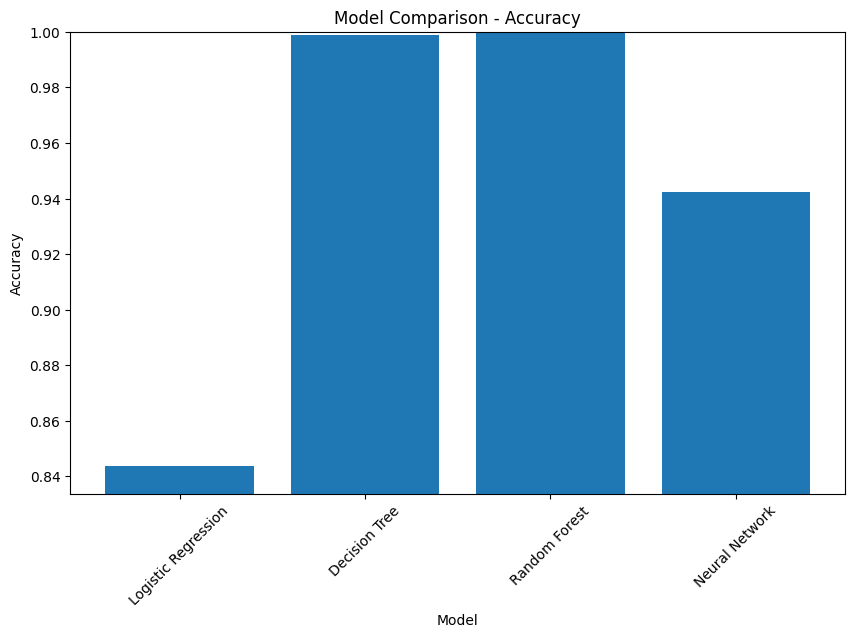

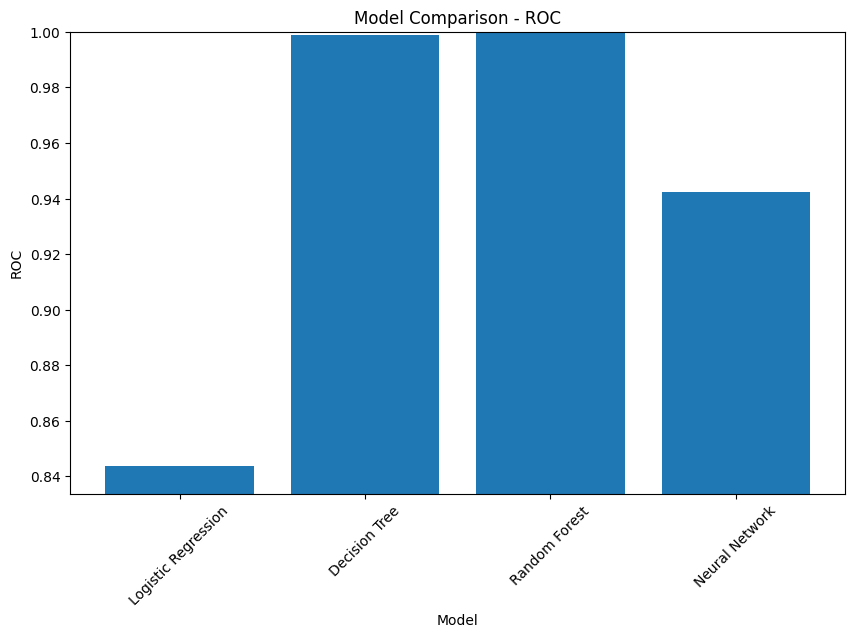

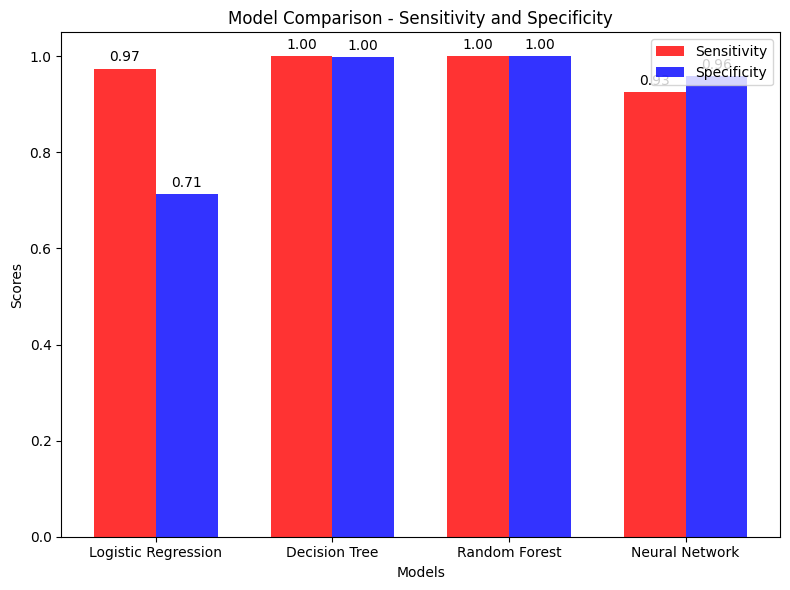

In [43]:
model_names = [name for name, _, _, _ in model_scores]
accuracy_scores = [acc for _, acc, _, _ in model_scores]
roc_scores = [roc for _, _, roc, _ in model_scores]

cms = [cm for _, _, _, cm in model_scores]

plot_scores(model_names, accuracy_scores, 'Accuracy')
plot_scores(model_names, roc_scores, 'ROC')

plot_specificity_sensitivity(model_names, cms)

### Best model parameters

In [ ]:
# best parameters for logistic regression
log_reg_best_params = {'C': 0.1, 'class_weight': {0: 0.1, 1: 0.9}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
# best parameters for decision tree
des_tree_best_params = {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
# best parameters for random forest
rand_for_best_params = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
# best parameters for neural network
mlp_for_best_params = {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}